In [1]:
from qutip import *
import matplotlib.pyplot as plt
import numpy as np

## A spin chain of three atoms
(As per this paper from Antoine Browaey's experiment: https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.114.113002.)
Three atoms coupled to two Rydberg states that have a resonant dipole-dipole interaction with each other. We start with the state $|\!\uparrow\downarrow\downarrow\rangle$ and look at how the excitation $\uparrow$ moves back and forth. For now we don't think about dephasing.

For $N$ atoms, the Hamiltonian we're dealing with is
$$ H = \frac{1}{2} \sum\limits_{i\neq j} \frac{C_3}{R_{ij}^3} \left( \sigma_i^+\sigma_j^- + \sigma_i^-\sigma_j^+ \right),$$
where $\sigma^{\pm} = \sigma^x \pm i\sigma^y$ such that this effectively describes a flip-flop interaction.

We define the Rydberg parameters:

In [110]:
C3 = 2*np.pi*7950   # MHz/um^3
R = 20       # um
N = 3

Now we define different operators. The individual spin-matrices work on a single atom, so we need to form tensor products to get a one-atom operator defined in the basis of the entire system. To this end we use the `tensor()` function in QuTiP. We need to cheat a little bit, and we'll assume that every atom has three states: $|\uparrow\rangle$, $|\downarrow\rangle$, and $|g\rangle$. The latter we just need so we can decay into it.

In [127]:
sigmaplus = []
sigmaminus = []
pops = []
szs = []
si = qeye(3)

pairoperators = []

for i in range(N):
    oplist = []
    for j in range(N):
        oplist.append(si)
    
    oplist[i] = Qobj([[0, 1, 0], [0, 0, 0], [0, 0, 0]])
    sigmaplus.append(tensor(oplist))

    oplist[i] = Qobj([[0, 0, 0], [1, 0, 0], [0, 0, 0]])
    sigmaminus.append(tensor(oplist))
    
    oplist[i] = Qobj([[0, 0, 0], [0, 1, 0], [0, 0, 0]])
    pops.append(tensor(oplist))
    
    oplist[i] = sigmaz()
    szs.append(tensor(oplist))

Having defined the operators, we can combine them to set up the Hamiltonian.

In [128]:
H = 0
for i in range(N):
    for j in range(i + 1, N):
        H += C3/(R*(j - i))**3 * ( sigmaplus[i] * sigmaminus[j] + sigmaminus[i] * sigmaplus[j] )

Define jump operators back down to the ground state

In [262]:
gammaDown = 1/135              # in us^-1
gammaUp = 1/101                # in us^-1, include the dephasing, see Sup. Mat. 
gamma0 = 1/2                   # in us^-1

Ls = []
for i in range(N):
    oplist = []
    for j in range(N):
        oplist.append(si)
    
    # DOWN spin decay
    oplist[i] = basis(3, 2) * basis(3, 0).dag()
    Ls.append( np.sqrt(gammaDown)*tensor(oplist) )
    
    # UP spin decay
    oplist[i] = basis(3, 2) * basis(3, 1).dag()
    Ls.append( np.sqrt(gammaUp)*tensor(oplist) )
    
    # dephasing, scrambles the phase
    oplist[i] = basis(3, 0) * basis(3, 0).dag()
    Ls.append( np.sqrt(gamma0)*tensor(oplist) )
    
    oplist[i] = basis(3, 1) * basis(3, 1).dag()
    Ls.append( np.sqrt(gamma0)*tensor(oplist) )

All that's left is defining intial conditions, and the times we want to state of our system. We define those here, and then we run a simple Schrödinger solver.

In [265]:
# Set up initial state, all spins down...
psi_list = []
for n in range(N):
    psi_list.append(basis(3, 0))

#... apart from one!
psi_list[0] = basis(3, 1)
psi0 = tensor(psi_list)

# Define time axis and run everything
tlist = np.linspace(0, 7, 10000)
result = mcsolve(H, psi0, tlist, e_ops = pops, c_ops = Ls, ntraj = 100)

10.0%. Run time:   4.44s. Est. time left: 00:00:00:39
20.0%. Run time:   5.43s. Est. time left: 00:00:00:21
30.0%. Run time:   6.70s. Est. time left: 00:00:00:15
40.0%. Run time:   7.64s. Est. time left: 00:00:00:11
50.0%. Run time:   9.06s. Est. time left: 00:00:00:09
60.0%. Run time:  10.04s. Est. time left: 00:00:00:06
70.0%. Run time:  11.50s. Est. time left: 00:00:00:04
80.0%. Run time:  12.46s. Est. time left: 00:00:00:03
90.0%. Run time:  14.15s. Est. time left: 00:00:00:01
100.0%. Run time:  15.10s. Est. time left: 00:00:00:00
Total run time:  15.15s


Plot the result.

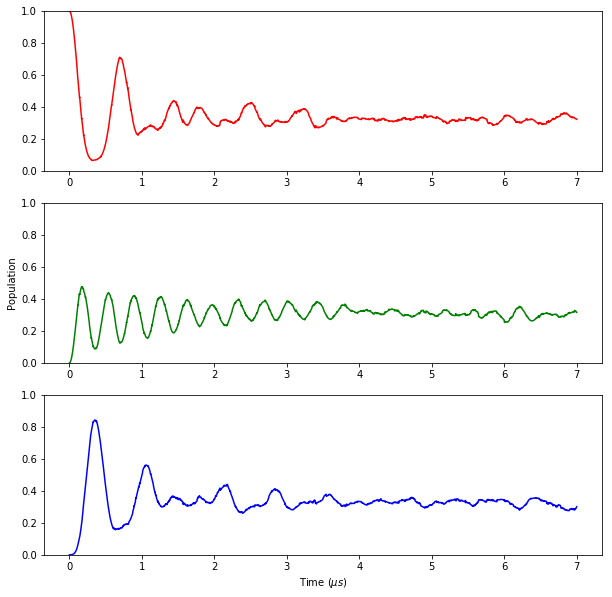

In [266]:
fig, ax = plt.subplots(3, 1, figsize=(10, 10))
colors = ['red', 'green', 'blue']
for i in range(N):
    ax[i].plot(tlist, result.expect[i], color = colors[i])
    ax[i].set_ylim([0,1])
    
ax[2].set_xlabel('Time ($\mu s$)')
ax[1].set_ylabel('Population')
plt.show()